In [58]:
import time
import torch
import numpy as np
import os

from scripts.model_builder import get_default_spec, save_model, load_model_only_inference
from scripts.transformer_prediction_interface import transformer_predict, get_params_from_config, TabPFNClassifier
from scripts.differentiable_pfn_evaluation import eval_model, eval_model_range
from scripts.model_builder import get_model, get_default_spec, save_model, load_model

from datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

from scripts import tabular_metrics
import random

In [59]:
base_path = '.'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load Datasets

In [60]:
max_samples = 10000
bptt = 10000

cc_test_datasets_multiclass, cc_test_datasets_multiclass_df = load_openml_list(open_cc_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)
cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = max_samples, num_feats=100, return_capped=True)

# Loading longer OpenML Datasets for generalization experiments (optional)
# test_datasets_multiclass, test_datasets_multiclass_df = load_openml_list(test_dids_classification, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

# Set the seed for the random number generator provided by PyTorch
torch.manual_seed(0)

# Set the seed for the random number generator provided by NumPy
np.random.seed(0)

random.seed(0)
random.shuffle(cc_valid_datasets_multiclass)

Number of datasets: 30
Loading balance-scale 11 ..
Loading mfeat-fourier 14 ..
Loading breast-w 15 ..
Loading mfeat-karhunen 16 ..
Loading mfeat-morphological 18 ..
Loading mfeat-zernike 22 ..
Loading cmc 23 ..
Loading credit-approval 29 ..
Loading credit-g 31 ..
Loading diabetes 37 ..
Loading tic-tac-toe 50 ..
Loading vehicle 54 ..
Loading eucalyptus 188 ..
Loading analcatdata_authorship 458 ..
Loading analcatdata_dmft 469 ..
Loading pc4 1049 ..
Loading pc3 1050 ..
Loading kc2 1063 ..
Loading pc1 1068 ..
Loading banknote-authentication 1462 ..
Loading blood-transfusion-service-center 1464 ..
Loading ilpd 1480 ..
Loading qsar-biodeg 1494 ..
Loading wdbc 1510 ..
Loading cylinder-bands 6332 ..
Loading dresses-sales 23381 ..
Loading MiceProtein 40966 ..
Loading car 40975 ..
Loading steel-plates-fault 40982 ..
Loading climate-model-simulation-crashes 40994 ..
Number of datasets: 150
Loading breast-cancer 13 ..
Loading colic 25 ..
Loading dermatology 35 ..
Loading sonar 40 ..
Loading glass 

In [61]:
def get_datasets(selector, task_type, suite='cc'):
    if task_type == 'binary':
        ds = valid_datasets_binary if selector == 'valid' else test_datasets_binary
    else:
        if suite == 'openml':
            ds = valid_datasets_multiclass if selector == 'valid' else test_datasets_multiclass
        elif suite == 'cc':
            ds = cc_valid_datasets_multiclass if selector == 'valid' else cc_test_datasets_multiclass
        else:
            raise Exception("Unknown suite")
    return ds

In [62]:
model_string, longer, task_type = '', 1, 'multiclass'
eval_positions = [1000]
bptt = 2000
    
test_datasets, valid_datasets = get_datasets('test', task_type, suite='cc'), get_datasets('valid', task_type, suite='cc')

# Pick single Dataset

In [63]:
evaluation_dataset_index = 8 # Index of the dataset to predict
ds = test_datasets[evaluation_dataset_index]
print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape}')

Evaluation dataset name: credit-g shape torch.Size([1000, 20])


## Split x and y in train and test

In [64]:
xs, ys = ds[1].clone(), ds[2].clone()
eval_position = xs.shape[0] // 2
train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
test_xs, test_ys = xs[eval_position:], ys[eval_position:]

## weighting for the ensemble (AUC/CE)

In [65]:
class PFNEnsemble:
    def __init__(self, 
                 eval_positions,
                 model_storage_folders=["models_gp"],
                 device="cpu",
                 N_ensemble_configurations=5,
                 verbose=False):
        self.model_dict = {}  # Maps model_index to loaded model
        
        for model_storage_folder in model_storage_folders:
            # Iterate over all files in the model_path directory
            for model_index, model_string in enumerate(os.listdir(model_storage_folder)):
                if model_string.endswith('.cpkt'):  # Assuming the models have a .cpkt extension
                    loaded_model = TabPFNClassifier(base_path=model_storage_folder,
                                                    model_string=model_string[:-5],
                                                    N_ensemble_configurations=N_ensemble_configurations,
                                                    batch_size_inference=1)
                    self.model_dict[model_index] = {"model": loaded_model, "name": f"{model_storage_folder}/{model_string}"}

    def fit(self, train_xs, train_ys):
        for model_index, model_auc_ce in self.model_dict.items():
            model = model_auc_ce["model"]
            model.fit(train_xs, train_ys)
            
    def get_split_of_train_data_simple(self, train_x, train_y, split_share):
        temp_split_pos = int(train_x.shape[0] * split_share)
        
        temp_split_train_x = train_x[:temp_split_pos]
        temp_split_test_x = train_x[temp_split_pos:]
        
        temp_split_train_y = train_y[:temp_split_pos]
        temp_split_test_y = train_y[temp_split_pos:]
        return [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
    
                
    def get_split_of_train_data_bagging(self, train_x, train_y, split_share, number_splits):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        for i in range(number_splits):
            temp_split_indices = random.sample(range(len(train_x)), int(split_share * len(train_x)))
            temp_split_train_x = [train_x[i] for i in temp_split_indices]
            temp_split_test_x = [train_x[i] for i in range(len(train_x)) if i not in temp_split_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_indices]
            temp_split_test_y = [train_y[i] for i in range(len(train_y)) if i not in temp_split_indices]
            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
    
    
    def get_split_of_train_data_pasting(self, train_x, train_y, split_share):
        splits = [] # each entry has format: [(temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y)]
        # todo repeat the following number_splits times and add each time to splits
        list_of_indices_to_sample = list(range(len(train_x)))
        while len(list_of_indices_to_sample) > 1: # need at least two 
            len_list_to_sample = len(list_of_indices_to_sample)
            if len_list_to_sample <= int(split_share * len(train_x)) * 2:
                temp_split_train_indices = list_of_indices_to_sample[:len_list_to_sample//2]
                temp_split_test_indices = list_of_indices_to_sample[len_list_to_sample//2:]
            else:    
                temp_split_train_indices = random.sample(list_of_indices_to_sample, int(split_share * len(train_x)))
                remaining_list_indices = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices]
                temp_split_test_indices = random.sample(remaining_list_indices,int(split_share * len(train_x)))
                
            # remove indices which has been sampled in temp_split_indices from list_of_indices_to_sample
            list_of_indices_to_sample  = [x for x in list_of_indices_to_sample if x not in temp_split_train_indices + temp_split_test_indices]

            temp_split_train_x = [train_x[i] for i in temp_split_train_indices]
            temp_split_test_x = [train_x[i] for i in temp_split_test_indices]

            temp_split_train_y = [train_y[i] for i in temp_split_train_indices]
            temp_split_test_y = [train_y[i] for i in temp_split_test_indices]

            splits.append((temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y))
        return splits
            
        
    def get_train_auc_ce_of_model(self,model,splits):
        # use accuracy / AUC  for the model weighing? How to interpret each of them? 
        # we have to cache the full training data as .fit will overwrite this in the model     
        total_auc = 0
        total_ce = 0
        for temp_split_train_x, temp_split_test_x, temp_split_train_y, temp_split_test_y in splits:
            model.fit(temp_split_train_x, temp_split_train_y)
            prediction_ = model.predict_proba(temp_split_test_x)
            auc= tabular_metrics.auc_metric(temp_split_test_y, prediction_)
            total_auc += auc
            ce = tabular_metrics.cross_entropy(temp_split_test_y, prediction_)
            total_ce += ce
            
        total_auc /= len(splits)
        total_ce /= len(splits)
        
        return auc, ce
        
    def compute_weights(self, dictionary, sum_of_auc, sum_of_ce, weighting_metric="auc", weight_type = "weighted_average"):  
        
        if weight_type=="weighted_average":
            #assign weight of model depending of ce
            for ensemble_index, model_auc_ce in dictionary.items():
                if weighting_metric == "auc":
                    dictionary[ensemble_index]["weight"] = dictionary[ensemble_index]["auc"] / sum_of_auc
                elif weighting_metric == "ce": 
                    # Determine the maximum cross-entropy value
                    ce_max = max(model_auc_ce["ce"] for model_auc_ce in dictionary.values())
                    sum_of_normalized_ce = 0
                    for ensemble_index, model_auc_ce in dictionary.items():
                        ce_normalized = ce_max - model_auc_ce["ce"]  # Subtract actual ce from ce_max
                        dictionary[ensemble_index]["weight"] = ce_normalized
                        sum_of_normalized_ce += ce_normalized
                    # Normalize the weights
                    for ensemble_index, model_auc_ce in dictionary.items():
                        dictionary[ensemble_index]["weight"] /= sum_of_normalized_ce
                else: 
                    raise NotImplementedError(f'The weighting_metric for the weights is not allowed: {weighting_metric}.')                    
        elif weight_type =="best_performer":
            max_entry = max(dictionary.items(), key=lambda x: x[1][weighting_metric])
            max_entry_key = max_entry[0]
            
            max_model_value = max_entry[1]
            for ensemble_index, model_auc_ce in dictionary.items():
                dictionary[ensemble_index]["weight"] = 0
                if ensemble_index == max_entry_key: 
                    dictionary[ensemble_index]["weight"] = 1
        else: 
            raise NotImplementedError(f'The weight_type is not allowed: {weight_type}.')    
        
        #print(dictionary)
        return dictionary

        
    def get_splits_of_train_data(self, full_train_x, full_train_y, split_type, split_share, number_splits):
        # compute the train data splits for later AUC / CE / ... computation
        if split_type == "simple":
            splits = self.get_split_of_train_data_simple(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        elif split_type == "bagging": 
            splits = self.get_split_of_train_data_bagging(train_x=full_train_x, train_y=full_train_y, split_share=split_share,number_splits=number_splits)
        elif split_type == "pasting": 
            splits = self.get_split_of_train_data_pasting(train_x=full_train_x, train_y=full_train_y, split_share=split_share)
        return splits
        
        
    def predict_proba(self, 
                      test_xs, 
                      weighing_ensemble_config = None,
                      data_preprocess_config = None, 
                      multiple_models=False,
                      pre_processing=False ):
        
        if multiple_models is False and pre_processing is True: # only preprocessing with one model
            print("TODO predict_proba use baseline if no moe config is given! ")
            # select baseline model --> for each data augmentation and given splittype and weighing type compute AUC / CE 
            # --> compute weights --> return weighted predictions
            baseline_model = None
            for model_index, model_auc_ce in self.model_dict.items():
                if "baseline" in model_auc_ce["name"]: 
                    baseline_model = self.model_dict[model_index]["model"]
                    break
                    
            if basline_model is None: 
                raise NotImplementedError(f'The basline_model could not be found for predict proba.')                    

            train_xs, train_ys = baseline_model.X_, baseline_model.y_
            
            # todo APPLY DATA PREPROCESSING / AUGMENTATION
            # TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO TODO
            augmented_data_xs_ys = []# dict of augmented data train_xs and train_ys in {"augm_name1": {"data":([xs', ys'], [xs'', ys''])},...}
            # --------------------------- UNTIL HERE
            
            sum_of_ce = 0
            sum_of_auc = 0
            augmentation_dict = {}
            for augmentation_name, full_train_data in augmented_data_xs_ys.items():
                full_train_x, full_train_y = full_train_data["data"]
                splits = self.get_splits_of_train_data(full_train_x=full_train_x,
                                                  full_train_y=full_train_y,
                                                  split_type=data_preprocess_config["split_type"], 
                                                  split_share=data_preprocess_config["split_share"])

                # Compute AUC / CE /... performance of train data 
                auc, ce = self.get_train_auc_ce_of_model(model=baseline_model,splits=splits) 
                auc, ce = float(auc), float(ce)

                if augmentation_name not in augmentation_dict:
                    augmentation_dict[augmentation_name] = {}
                augmentation_dict[augmentation_name]["auc"] = auc
                augmentation_dict[augmentation_name]["ce"] = ce
                augmentation_dict[augmentation_name]["weight"] = 0
                                
                sum_of_ce += ce
                sum_of_auc += auc
                
            baseline_model.fit(train_xs, train_ys) # overwrite the training data in the model again! 
            
            # after having collected the auc / ce /... scores of the models of the train set, we want to compute the weights for the final forward pass
            weights_dict = self.compute_weights(dictionary=augmentation_dict,
                                 sum_of_auc=sum_of_auc,
                                 sum_of_ce=sum_of_ce,
                                 weighting_metric=data_preprocess_config["weighting_metric"],
                                 weight_type=data_preprocess_config["weight_type"])
            
            prediction__weighted = 0
            for augmentation_name, model_auc_ce in weights_dict.items():
                prediction_ = baseline_model.predict_proba(test_xs) 
                prediction__weighted += torch.tensor(prediction_) *  augmentation_dict[augmentation_name]["weight"]                
            return prediction__weighted

            
        elif multiple_models is True and pre_processing is False: # only moe ensembling
            print("predict_proba use moe pipeline if no data preprocessing is given")
            sum_of_ce = 0
            sum_of_auc = 0
            moe_dict = {}
            for model_index, model_auc_ce in self.model_dict.items():
                
                model = model_auc_ce["model"]
                full_train_x, full_train_y = model.X_, model.y_ 
                 
                # compute the train data splits for later AUC / CE / ... computation
                splits = self.get_splits_of_train_data(full_train_x=full_train_x,
                                              full_train_y=full_train_y,
                                              split_type=weighing_ensemble_config["split_type"], 
                                              split_share=weighing_ensemble_config["split_share"], 
                                                number_splits= weighing_ensemble_config["number_splits"])

                # Compute AUC / CE /... performance of train data 
                auc, ce = self.get_train_auc_ce_of_model(model=model,splits=splits) 
                auc, ce = float(auc), float(ce)

                model.fit(full_train_x, full_train_y) # overwrite the training data in the model again! 
            
                if model_index not in moe_dict: 
                    moe_dict[model_index] = {}
                moe_dict[model_index]["auc"] = auc
                moe_dict[model_index]["ce"] = ce
                
                sum_of_ce += ce
                sum_of_auc += auc

            # after having collected the auc / ce /... scores of the models of the train set, we want to compute the weights for the final forward pass
            weights_dict = self.compute_weights( dictionary=moe_dict,
                                             sum_of_auc=sum_of_auc,
                                             sum_of_ce=sum_of_ce,
                                             weighting_metric=weighing_ensemble_config["weighting_metric"],
                                             weight_type=weighing_ensemble_config["weight_type"] )
            prediction__weighted = 0
            for model_index, model_auc_ce in self.model_dict.items():
                prediction_ = model_auc_ce["model"].predict_proba(test_xs) 
                prediction__weighted += torch.tensor(prediction_) * weights_dict[model_index]["weight"]                
            return prediction__weighted
        
        else: # both datapreprocessing for each in moe ensembling
            print(f"TODO data preprocessing and moe both used!" )
                  
        

In [66]:
#model_path = "./models_gp"
#classifier_ensemble = PFNEnsemble(eval_positions=eval_position, model_storage_folder=model_path, device=device, verbose=False)
#classifier_ensemble.fit(train_xs, train_ys)
#prediction_ = classifier_ensemble.predict_proba(test_xs, metric="auc",split_type="bagging")
#auc, ce = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)
#'AUC', float(auc), 'Cross Entropy', float(ce)

## Ensemble with MOE Approach


In [71]:
import traceback
import time

model_paths = ["./models_gp","./models_causal","./baseline"]    
    
classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1)

weighting_metrics = ["auc", "ce"] #["auc", "ce"]
weight_types = ["best_performer","weighted_average"]# ["weighted_average", "best_performer"]
split_types =["simple", "bagging", "pasting"]# ["simple", "bagging", "pasting"]


results = {}
best_performers = []

start = 0
end =  2
number_iterations = range(max(start, 0),min(end,len(test_datasets)))#range(len(test_datasets)):# Index of the dataset to predict

for evaluation_dataset_index in number_iterations:
    
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
    try:
        start_time = time.time()
        classifier_tabpfn.fit(train_xs, train_ys)
        prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
        elapsed_time = time.time() - start_time 
        
        auc_tabpfn, ce_tabpfn = tabular_metrics.auc_metric(test_ys, prediction_tabpfn), tabular_metrics.cross_entropy(test_ys, prediction_tabpfn)
        
        # add computed results to result dict
        if "tabpfn" not in results:
            results["tabpfn"] = {}
            results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
            results["tabpfn"]["ce"] = np.zeros(len(number_iterations))
            results["tabpfn"]["time"] = np.zeros(len(number_iterations))

        results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn.item()
        results["tabpfn"]["ce"][evaluation_dataset_index - start] = ce_tabpfn.item()
        results["tabpfn"]["time"][evaluation_dataset_index - start] = elapsed_time  
        
    except Exception as e:
        print(f"Exception occured during tabpfn fitting / prediction")
        

    # MoE Configurations ---------------------
    for weighting_metric in weighting_metrics: 
        for weight_type in weight_types: 
            for split_type in split_types:
                print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")
                # --------------------------------
                weighing_ensemble_config = {"weighting_metric":weighting_metric,
                              "weight_type":weight_type,
                              "split_type":split_type,
                              "split_share":0.5, 
                             "number_splits": 5}
                data_preprocess_config = None
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(eval_positions=eval_position,
                                           model_storage_folders=model_paths,
                                           N_ensemble_configurations=5,
                                           device=device)

                try: 
                    start_time = time.time()
                    classifier_ensemble.fit(train_xs, train_ys)
                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                    weighing_ensemble_config = weighing_ensemble_config,
                                                                    data_preprocess_config=data_preprocess_config, 
                                                                    multiple_models=True,
                                                                    pre_processing=False )
                    # Calculate the elapsed time
                    
                    elapsed_time = time.time() - start_time 
                    auc_ensemble, ce_ensemble = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)

                    # add computed results to results dict
                    key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"

                    if key_name not in results:
                        results[key_name] = {}
                        results[key_name]["auc"] = np.zeros(len(number_iterations))
                        results[key_name]["ce"] = np.zeros(len(number_iterations))
                        results[key_name]["time"] = np.zeros(len(number_iterations))
                    results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble.item()
                    results[key_name]["ce"][evaluation_dataset_index - start] = ce_ensemble.item()
                    results[key_name]["time"][evaluation_dataset_index - start] = elapsed_time      

                except Exception as e:
                    print(e)
                    break

Evaluation dataset name: balance-scale shape torch.Size([625, 4]) --- 0/30
Current configuration: weighting_metric auc, weight_type best_performer, split_type simple
predict_proba use moe pipeline if no data preprocessing is given


KeyboardInterrupt: 

In [68]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    baseline_auc = results[baseline_model]['auc']
    model_auc = model_metrics['auc']
    
    # Perform paired t-test
    t_statistic, p_value = ttest_rel(baseline_auc, model_auc)
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    if p_value < 0.05:
        results[model_name]['significance'] = "Significantly better"
    else:
        results[model_name]['significance'] = "Not significantly better"



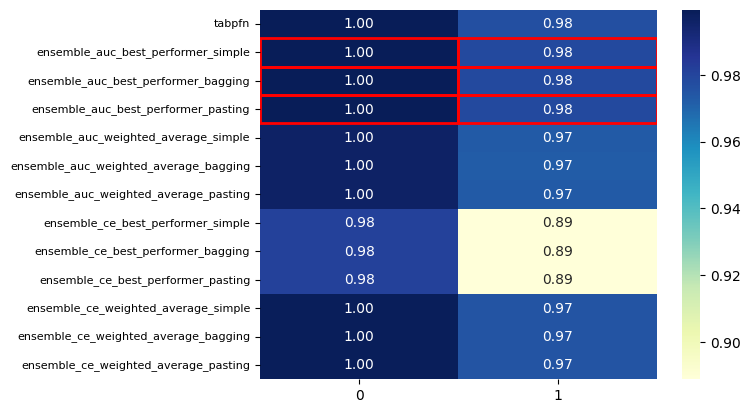

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
baseline_model = 'tabpfn'

# Convert the dictionary to a DataFrame
df_data = {model_name: model_metrics['auc'] for model_name, model_metrics in results.items()}
df = pd.DataFrame.from_dict(df_data, orient="index")

# Create the heatmap
ax = sns.heatmap(df, annot=True, fmt=".2f", cmap="YlGnBu")
ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)

# Find the maximum value in each column
max_values = df.max(axis=0)

# Add rectangles for the best performing model in each dataset
for col in range(df.shape[1]):
    highest_indices = np.where(df.iloc[:, col] == max_values[col])[0]
    for row in highest_indices:
        ax.add_patch(plt.Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))

        model_name = df.index[row]
        if model_name != baseline_model:
            baseline_auc = results[baseline_model]['auc']
            model_auc = results[model_name]['auc']
            t_statistic, p_value = ttest_rel(baseline_auc, model_auc)
            if p_value < 0.05:
                ax.text(col + 0.5, row + 0.5, '*', color='red', fontsize=12, ha='center', va='center')
                print(f"significant: {model_name}")

plt.show()  # Show the plot

In [70]:
import numpy as np
from scipy.stats import ttest_rel

baseline_model = 'tabpfn'
baseline_auc = results[baseline_model]['auc']

for model_name, model_metrics in results.items():
    if model_name == baseline_model:
        continue

    model_auc = model_metrics['auc']
    
    # Perform paired t-test on aggregated auc values
    t_statistic, p_value = ttest_rel(np.hstack(baseline_auc), np.hstack(model_auc))
    
    # Check if the p-value is below a significance threshold (e.g., 0.05)
    if p_value < 0.05:
        print(f"{model_name} is significantly better performing than {baseline_model} across all datasets.")
    else:
        pass
        #print(f"{model_name} is not significantly better performing than {baseline_model} across all datasets.")


## Ensemble with Data Preprocessing Approach


In [13]:
import traceback
import time
 
classifier_tabpfn = TabPFNClassifier(device=device, 
                                     base_path="./baseline",
                                     model_string="downloaded_tabpfn",
                                     N_ensemble_configurations=1,
                                     batch_size_inference=1)

weighting_metrics = ["auc", "ce"] #["auc", "ce"]
weight_types = ["best_performer","weighted_average"]# ["weighted_average", "best_performer"]
split_types =["simple", "bagging", "pasting"]# ["simple", "bagging", "pasting"]


results = {}
best_performers = []

start = 0
end =  2
number_iterations = range(max(start, 0),min(end,len(test_datasets)))#range(len(test_datasets)):# Index of the dataset to predict

for evaluation_dataset_index in number_iterations:
    ds = test_datasets[evaluation_dataset_index]
    print(f'Evaluation dataset name: {ds[0]} shape {ds[1].shape} --- {evaluation_dataset_index}/{len(test_datasets)}')

    xs, ys = ds[1].clone(), ds[2].clone()
    #-----------------------------
    xs = torch.where(torch.isnan(xs), torch.tensor(0.0), xs)
    ys = torch.where(torch.isnan(ys), torch.tensor(0), ys.long())
    #-----------------------------
    eval_position = xs.shape[0] // 2
    train_xs, train_ys = xs[0:eval_position], ys[0:eval_position]
    test_xs, test_ys = xs[eval_position:], ys[eval_position:]
    
    # compare to normal tabpfn
    try:
        start_time = time.time()
        classifier_tabpfn.fit(train_xs, train_ys)
        prediction_tabpfn = classifier_tabpfn.predict_proba(test_xs)
        elapsed_time = time.time() - start_time 
        
        auc_tabpfn, ce_tabpfn = tabular_metrics.auc_metric(test_ys, prediction_tabpfn), tabular_metrics.cross_entropy(test_ys, prediction_tabpfn)
        
        # add computed results to result dict
        if "tabpfn" not in results:
            results["tabpfn"] = {}
            results["tabpfn"]["auc"] = np.zeros(len(number_iterations))
            results["tabpfn"]["ce"] = np.zeros(len(number_iterations))
            results["tabpfn"]["time"] = np.zeros(len(number_iterations))

        results["tabpfn"]["auc"][evaluation_dataset_index - start] = auc_tabpfn.item()
        results["tabpfn"]["ce"][evaluation_dataset_index - start] = ce_tabpfn.item()
        results["tabpfn"]["time"][evaluation_dataset_index - start] = elapsed_time  
        
    except Exception as e:
        print(f"Exception occured during tabpfn fitting / prediction")
        

    # MoE Configurations ---------------------
    for weighting_metric in weighting_metrics: 
        for weight_type in weight_types: 
            for split_type in split_types:
                print(f"Current configuration: weighting_metric {weighting_metric}, weight_type {weight_type}, split_type {split_type}")
                # --------------------------------
                weighing_ensemble_config = {"weighting_metric":weighting_metric,
                              "weight_type":weight_type,
                              "split_type":split_type,
                              "split_share":0.5, 
                             "number_splits": 5}
                
                data_preprocess_config = {"N_ensemble_configurations": 5, } 
                
                # create classifier with configuration 
                classifier_ensemble = PFNEnsemble(eval_positions=eval_position,
                                           model_storage_folders=model_paths,
                                           N_ensemble_configurations=data_preprocess_config["N_ensemble_configurations"],
                                           device=device)

                try: 
                    start_time = time.time()
                    classifier_ensemble.fit(train_xs, train_ys)
                    prediction_ = classifier_ensemble.predict_proba(test_xs,
                                                                    weighing_ensemble_config = weighing_ensemble_config,
                                                                    data_preprocess_config=data_preprocess_config,
                                                                    multiple_models=False,
                                                                    pre_processing=True )
                    # Calculate the elapsed time
                    elapsed_time = time.time() - start_time 
                    auc_ensemble, ce_ensemble = tabular_metrics.auc_metric(test_ys, prediction_), tabular_metrics.cross_entropy(test_ys, prediction_)

                    # add computed results to results dict
                    key_name = f"ensemble_{weighting_metric}_{weight_type}_{split_type}"

                    if key_name not in results:
                        results[key_name] = {}
                        results[key_name]["auc"] = np.zeros(len(number_iterations))
                        results[key_name]["ce"] = np.zeros(len(number_iterations))
                        results[key_name]["time"] = np.zeros(len(number_iterations))
                    results[key_name]["auc"][evaluation_dataset_index - start] = auc_ensemble.item()
                    results[key_name]["ce"][evaluation_dataset_index - start] = ce_ensemble.item()
                    results[key_name]["time"][evaluation_dataset_index - start] = elapsed_time      

                except Exception as e:
                    print(e)
                    break